In [176]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pyfolio as pf
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn_som.som import SOM
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from empyrical.utils import nanmean, nanstd

In [177]:
file = '/Users/hannes/Downloads/540136b93e7be9e7b2edabcebb808dd8.json'
with open(file) as f:  
    data = json.load(f)

In [178]:
x_items = []
y_items = []
for item in data['Charts']['Strategy Equity']['Series']['Equity']['Values']:
    x_items.append(item['x'])
    y_items.append(item['y'])

x_items_b = []
y_items_b = []
for item in data['Charts']['Benchmark']['Series']['Benchmark']['Values']:
    x_items_b.append(item['x'])
    y_items_b.append(item['y'])

x_items = [datetime.fromtimestamp(x) for x in x_items]
x_items_b = [datetime.fromtimestamp(x) for x in x_items_b]

In [179]:
strat_df = pd.DataFrame(y_items, index = x_items, columns = ['Strategy'])
bench_df = pd.DataFrame(y_items_b, index = x_items_b, columns = ['Benchmark'])

# Get first and last dates
strat_rtns = strat_df.pct_change().dropna()
min_date = strat_rtns[strat_rtns['Strategy'] != 0].index.min() - timedelta(days=1)
max_date = strat_rtns.index.max()
print(f'min date {min_date} max date {max_date}')

# Have same starting point for both
strat_df = strat_df[min_date:]
bench_df = bench_df[min_date:]

# Rebase
strat_df = strat_df/strat_df.iloc[0]
bench_df = bench_df/bench_df.iloc[0]

# Resample to daily data 
strat_df = strat_df.resample('D').last()
bench_df = bench_df.resample('D').last()

min date 2016-04-01 11:00:00 max date 2022-10-15 11:00:00


<AxesSubplot:>

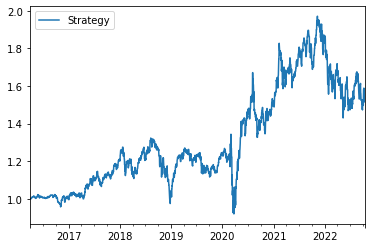

In [180]:
strat_df.plot()

<AxesSubplot:>

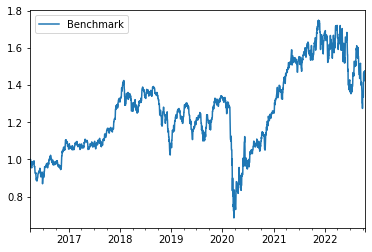

In [181]:
bench_df.plot()

In [182]:
def cum_returns(df: pd.DataFrame) -> float:
    return df.iloc[-1].values[0]/df.iloc[0].values[0]

In [183]:
def calc_sharpe(df: pd.DataFrame) -> float:
    '''
    Sharpe Ratio = ( returns(p) - returns(f) )/ standard deviation(p)
    where rf = 0
    '''
    df_temp = df.copy()
    df_temp['rtns'] = df_temp.pct_change()
    sharpe = df_temp['rtns'].mean() / df_temp['rtns'].std()
    return sharpe * np.sqrt(252)

In [184]:
def calc_sortino(df: pd.DataFrame) -> float:
    '''
    Sorting Ratio = ( returns(p) - returns(f) )/ standard deviation(p) of negative returns
    where rf = 0
    '''
    df_temp = df.copy()
    df_temp['rtns'] = df_temp.pct_change()
    sharpe = df_temp['rtns'].mean() / df_temp['rtns'][df_temp['rtns'] <0].std()
    return sharpe * np.sqrt(252)

In [185]:
def max_drawdown(df: pd.DataFrame) -> float:
    rtns = df.pct_change()
    series = rtns.iloc[:,0]
    cum_ret = (series+1).cumprod()
    peak = cum_ret.expanding(min_periods=1).max()
    dd = (cum_ret/peak)-1
    return dd.min()

In [186]:
def stats(df):
    print(f'cum returns: {cum_returns(df)}')
    print(f'sharpe: {calc_sharpe(df)}')
    print(f'sortino: {calc_sortino(df)}')
    print(f'max dd: {max_drawdown(df)}')

In [187]:
stats(strat_df)

cum returns: 1.5174445696
sharpe: 0.3249929171538888
sortino: 0.3373412687788152
max dd: -0.3150534532337399


In [188]:
stats(bench_df)

cum returns: 1.424593993000132
sharpe: 0.2861581872995356
sortino: 0.29830789158392274
max dd: -0.5194576696516064


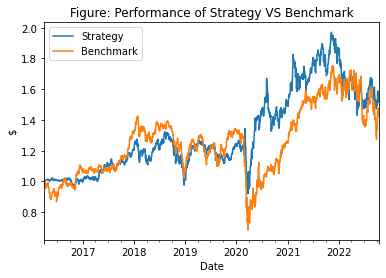

In [189]:
# Plot cumulative returns
ax = strat_df.plot()
bench_df.plot(ax=ax)
plt.ylabel('$')
plt.xlabel('Date')
plt.title('Figure: Performance of Strategy VS Benchmark')
plt.show()

<AxesSubplot:title={'center':'Underwater plot'}, ylabel='Drawdown'>

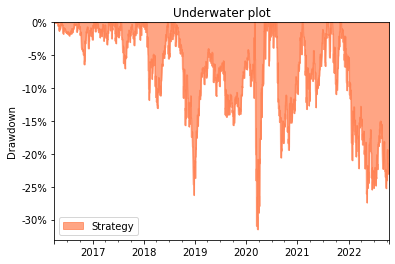

In [190]:
pf.plot_drawdown_underwater(strat_df.pct_change())

<AxesSubplot:title={'center':'Underwater plot'}, ylabel='Drawdown'>

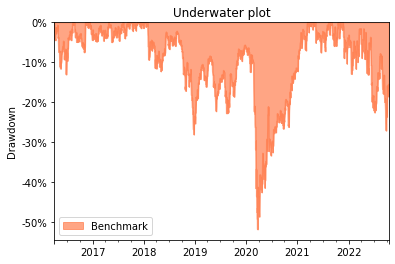

In [191]:
pf.plot_drawdown_underwater(bench_df.pct_change())

In [192]:
def compute_regimes(start_date, end_date, k=8):
    print(start_date, end_date)
    nasdaq = web.DataReader('NASDAQCOM', "fred", start_date, end_date).dropna().resample('W').last() 
    nasdaq2= nasdaq.pct_change(periods=4)[1:] # compute weekly returns
    infl=web.DataReader('CPIAUCSL', "fred", start_date, end_date).dropna()
    infl2=infl.pct_change(periods=12)[1:] # inflation wrt prior year
    infl3=infl2.dropna().resample('W').mean().interpolate() # resample to weekly data
    int_rate=web.DataReader('DFF', "fred", start_date, end_date).dropna()
    int_rate2=int_rate.resample('W').mean() # resample to weekly data

    aux=nasdaq2
    aux['INFLATION']=infl3
    aux['INTEREST_R']=int_rate2
    aux=aux.dropna()

    scaler = StandardScaler() # scale data to std normal
    scaler.fit(aux)
    norm_data=pd.DataFrame(scaler.transform(aux),index=aux.index,columns=aux.columns)

    som = SOM(m=k, n=1, dim=norm_data.shape[1]) # Self-Organising Map
    som.fit(norm_data.to_numpy())
    hs = som.predict(norm_data.to_numpy())
    st = pd.DataFrame(hs,index=norm_data.index)
    data = pd.concat([norm_data,st],axis=1,sort='False').dropna()
    data.rename(columns={0:'REGIME'}, inplace=True)
    return data


In [193]:
regimes = compute_regimes(start_date=(min_date - timedelta(days=400)).strftime("%Y-%m-%d"), end_date=max_date.strftime("%Y-%m-%d"))

2015-02-26 2022-10-15


/var/folders/5r/3sxxysys3kb_pxzpp4npjd9h0000gn/T/ipykernel_26106/490563439.py:24: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  data = pd.concat([norm_data,st],axis=1,sort='False').dropna()


In [194]:
date_df = pd.DataFrame(0,index=pd.date_range(start=min_date, end=max_date).date, columns=['0'])
date_regimes = date_df.join(regimes).backfill()
combined_df = date_regimes.dropna(axis=0).join(strat_df)
combined_df['Strategy'] = combined_df['Strategy']/combined_df['Strategy'][0]
combined_df['rtns'] = combined_df['Strategy'].pct_change()
combined_df = combined_df.dropna(axis=0, how='any')
combined_df

,0,NASDAQCOM,INFLATION,INTEREST_R,REGIME,Strategy,rtns
2016-04-02,0,0.523519,-0.775341,-0.742468,4.0,1.000949,0.000949
2016-04-03,0,0.523519,-0.775341,-0.742468,4.0,1.000949,0.000000
2016-04-04,0,0.146829,-0.785529,-0.722073,4.0,1.000949,0.000000
2016-04-05,0,0.146829,-0.785529,-0.722073,4.0,1.000085,-0.000863
2016-04-06,0,0.146829,-0.785529,-0.722073,4.0,1.000690,0.000605
...,...,...,...,...,...,...,...
2022-08-31,0,-1.753374,2.276216,1.609771,7.0,1.575910,-0.009494
2022-09-01,0,-1.753374,2.276216,1.609771,7.0,1.559964,-0.010119
2022-09-02,0,-1.753374,2.276216,1.609771,7.0,1.547668,-0.007882
2022-09-03,0,-1.753374,2.276216,1.609771,7.0,1.531070,-0.010725


In [195]:
import plistlib
from scipy import stats as stats

regime_list = []
ann_rts_list = []
p_list = []

for regime in sorted(combined_df.REGIME.unique()):
    rtns = combined_df[combined_df.REGIME == regime]['rtns']
    mean_rtns = rtns.mean()
    count = rtns.count()
    # print(mean_rtns, count)

    # T_Test
    # H0 : no statistically significant difference between the total returns and returns in individual regimes
    a = combined_df['rtns'].to_numpy()
    b = combined_df[combined_df.REGIME == regime]['rtns'].to_numpy()
    p = stats.ttest_ind(a,b,equal_var=True)[1]
    
    # Annualized returns
    ann_rtns = (1 + mean_rtns)**252 - 1

    # Append to lists to create dataframe
    regime_list.append(f'{regime:.0f}')
    ann_rts_list.append(ann_rtns)
    p_list.append(p)

regime_results = pd.DataFrame({'Regime':regime_list,'Annual_Returns':ann_rts_list,'P_Value':p_list})
regime_results

,Regime,Annual_Returns,P_Value
0,0,-0.408355,0.014585
1,1,-0.118470,0.368229
2,2,0.244254,0.419077
3,3,0.279799,0.271048
4,4,0.562415,0.016144
5,5,-0.089459,0.358681
6,6,0.190212,0.595283
7,7,-0.216693,0.125764


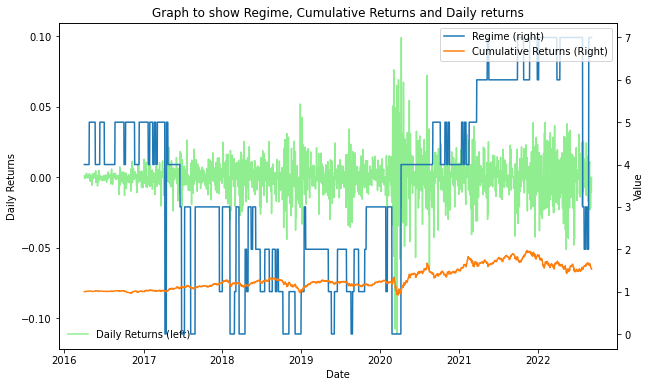

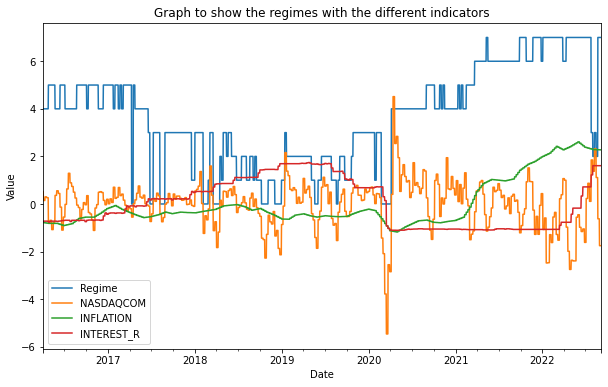

In [202]:
import matplotlib.pyplot as plt

results_df = combined_df.rename(columns={'REGIME':'Regime','Strategy':'Cumulative Returns','rtns':'Daily Returns'})

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(results_df['Daily Returns'], color = 'lightgreen')
ax.set_xlabel('Date')
ax.set_ylabel('Daily Returns')
ax.legend(['Daily Returns (left)'], loc='lower left', framealpha = 0)

ax2 = ax.twinx()

ax2.plot(results_df[['Regime','Cumulative Returns']])
ax2.set_ylabel('Value')

ax2.legend(['Regime (right)','Cumulative Returns (Right)'], loc = 'upper right')

plt.title('Graph to show Regime, Cumulative Returns and Daily returns')
plt.show()


results_df[['Regime','NASDAQCOM','INFLATION','INTEREST_R']].plot(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Graph to show the regimes with the different indicators')
plt.show()